# Tutorial on how to use the Arinyo model

In this notebook we explain how to compute P3D and P1D from a particular Arinyo model

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

In [2]:
from lace.cosmo import camb_cosmo
import forestflow
from forestflow.archive import GadgetArchive3D
from forestflow.model_p3d_arinyo import get_linP_interp
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.P3D_cINN import P3DEmulator

## Arinyo model from default cosmo and params

For more details about the Arinyo model see Eq. 4.5 from Givans+22 (https://arxiv.org/abs/2205.00962)

In [3]:
zs = np.array([3]) # set target redshift
cosmo = camb_cosmo.get_cosmology() # set default cosmo
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=200) # set default cosmo
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=200) # set model
arinyo.default_params

{'bias': -0.18,
 'beta': 1.3,
 'q1': 0.4,
 'q2': 0.0,
 'kvav': 0.58,
 'av': 0.29,
 'bv': 1.55,
 'kp': 10.5}

### Compute P3D & P1D

In [4]:
nn_k = 200 # number of k bins
nn_mu = 10 # number of mu bins
k = np.logspace(-1.5, 1, nn_k)
mu = np.linspace(0, 1, nn_mu)
k2d = np.tile(k[:, np.newaxis], nn_mu) # k grid for P3D
mu2d = np.tile(mu[:, np.newaxis], nn_k).T # mu grid for P3D

kpar = np.logspace(-1, np.log10(5), nn_k) # kpar for P1D

plin = arinyo.linP_Mpc(zs[0], k) # get linear power spectrum at target z
p3d = arinyo.P3D_Mpc(zs[0], k2d, mu2d, arinyo.default_params) # get P3D at target z
p1d = arinyo.P1D_Mpc(zs[0], kpar, parameters=arinyo.default_params) # get P1D at target z

#### Plot P3D

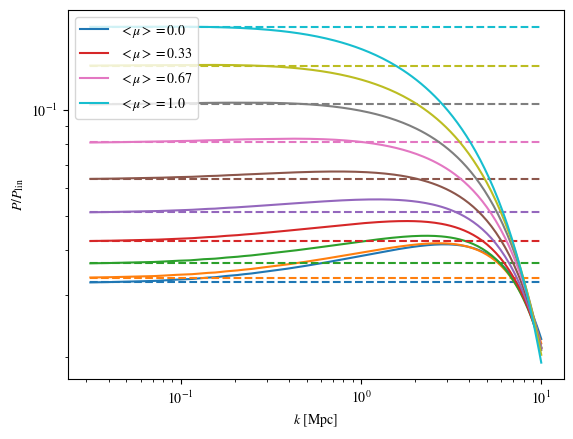

In [5]:
for ii in range(p3d.shape[1]):
    col = 'C'+str(ii)
    if ii % 3 == 0:
        lab = r'$<\mu>=$'+str(np.round(mu[ii], 2))
    else:
        lab = None
    plt.loglog(k, p3d[:, ii]/plin, col, label=lab)
    plt.plot(k, p3d[0, ii]/plin[0]+k[:]*0, col+'--')
plt.xlabel(r'$k$ [Mpc]')
plt.ylabel(r'$P/P_{\rm lin}$')
plt.legend(loc='upper left')

#### Plot P1D

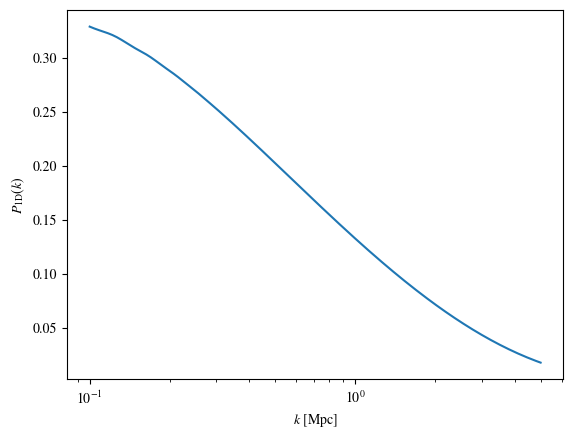

In [6]:
plt.plot(kpar, p1d)
plt.xlabel(r'$k$ [Mpc]')
plt.ylabel(r'$P_{\rm 1D}(k)$')
plt.xscale('log')

### Best-fitting Arinyo model to LaCE simulation

The Arinyo model was optimized to reproduce both the P3D and P1D down to 4 Mpc (both)

Read sims

In [7]:
path_forestflow= os.path.dirname(forestflow.__path__[0]) + "/"
Archive3D = GadgetArchive3D(
    base_folder=path_forestflow,
    folder_data=path_forestflow+"/data/best_arinyo/",
)

In [60]:
ind_book = 6 # select a random simulation

zs = np.array([Archive3D.training_data[ind_book]['z']]) 

k3d_Mpc = Archive3D.training_data[ind_book]['k3d_Mpc']
mu3d = Archive3D.training_data[ind_book]['mu3d']
p3d_Mpc = Archive3D.training_data[ind_book]['p3d_Mpc']
Plin = Archive3D.training_data[ind_book]['Plin']

k1d_Mpc = Archive3D.training_data[ind_book]['k_Mpc']
p1d_Mpc = Archive3D.training_data[ind_book]['p1d_Mpc']

arinyo_params = Archive3D.training_data[ind_book]['Arinyo_minin'] # best-fitting Arinyo params
print(zs)
arinyo_params

[3.]


{'bias': 0.22406834169113488,
 'beta': 1.254562019747339,
 'q1': 0.4349270203960536,
 'kvav': 0.7496441169756451,
 'av': 0.4549565540373915,
 'bv': 1.7940055182259969,
 'kp': 13.89183552512316,
 'q2': 0.43711418395299595}

#### Plot P3D from simulation

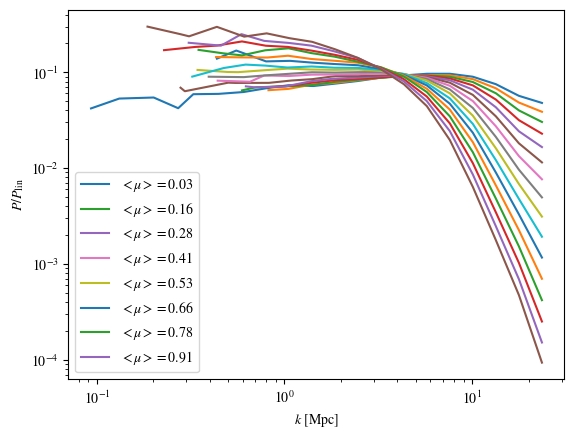

In [46]:
for ii in range(0, p3d_Mpc.shape[1]):
    if ii % 2 == 0:
        lab = r'$<\mu>=$'+str(np.round(mu3d[-1,ii], 2))
    else:
        lab = None
    plt.loglog(k3d_Mpc[:, ii], p3d_Mpc[:, ii]/Plin[:, ii], label=lab)
plt.xlabel(r'$k$ [Mpc]')
plt.ylabel(r'$P/P_{\rm lin}$')
plt.legend(loc='lower left')

#### Compare P3D from simulation and best-fitting Arinyo

In [47]:
model_p3d = Archive3D.training_data[ind_book]['model'].P3D_Mpc(zs, k3d_Mpc, mu3d, arinyo_params)

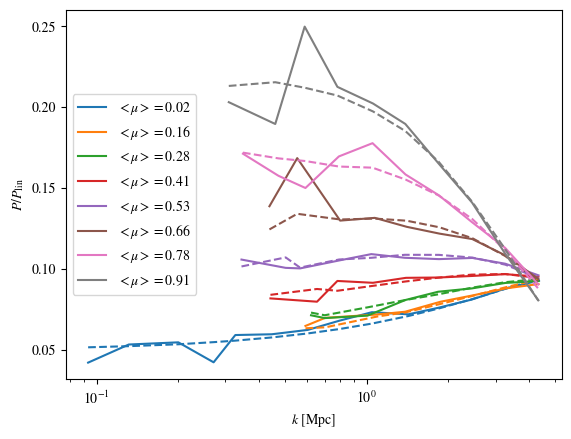

In [48]:
jj = 0
mask = k3d_Mpc[:,0] < 5
for ii in range(0, p3d_Mpc.shape[1], 2):
    col = 'C'+str(jj)
    lab = r'$<\mu>=$'+str(np.round(np.nanmean(mu3d[:,ii]), 2))
    plt.plot(k3d_Mpc[mask, ii], p3d_Mpc[mask, ii]/Plin[mask, ii], col+'-', label=lab)
    plt.plot(k3d_Mpc[mask, ii], model_p3d[mask, ii]/Plin[mask, ii], col+'--')
    jj += 1
plt.xscale('log')
plt.xlabel(r'$k$ [Mpc]')
plt.ylabel(r'$P/P_{\rm lin}$')
plt.legend()

#### Ratio

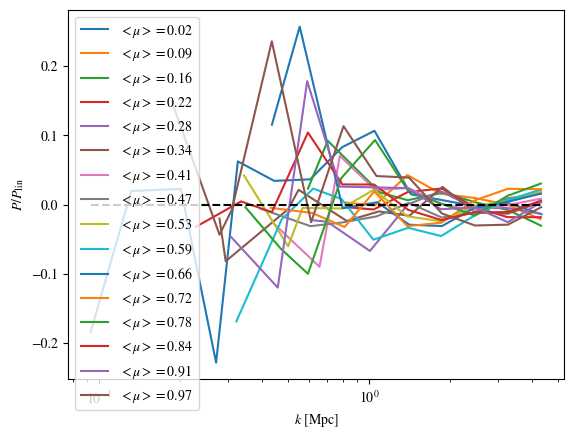

In [49]:
mask = k3d_Mpc[:,0] < 5
for ii in range(0, p3d_Mpc.shape[1]):
    lab = r'$<\mu>=$'+str(np.round(np.nanmean(mu3d[:,ii]), 2))
    plt.plot(k3d_Mpc[mask, ii], p3d_Mpc[mask, ii]/model_p3d[mask, ii]-1, label=lab)
plt.plot(k3d_Mpc[mask, 0], k3d_Mpc[mask, 0]*0, 'k--')
plt.xscale('log')
plt.xlabel(r'$k$ [Mpc]')
plt.ylabel(r'$P/P_{\rm lin}$')
plt.legend()

#### Same for P1D

In [50]:
model_p1d = Archive3D.training_data[ind_book]['model'].P1D_Mpc(zs, k1d_Mpc, parameters=arinyo_params)

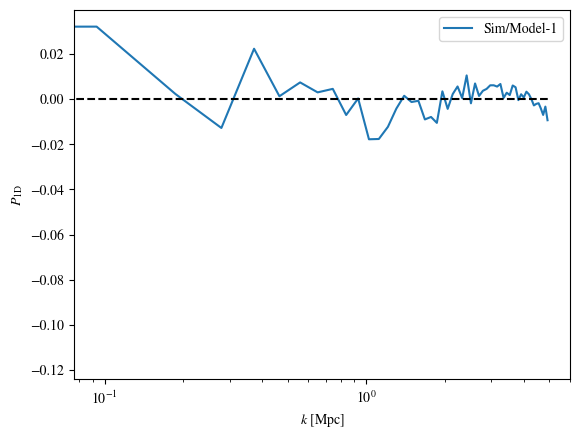

In [51]:
mask = k1d_Mpc < 4
plt.plot(k1d_Mpc[mask], p1d_Mpc[mask]/model_p1d[mask]-1, '-', label='Sim/Model-1')
plt.plot(k1d_Mpc[mask], k1d_Mpc[mask]*0, 'k--')
plt.xscale('log')
plt.xlabel(r'$k$ [Mpc]')
plt.ylabel(r'$P_{\rm 1D}$')
plt.legend()

## Arinyo model from emulator

#### Train emulator (takes 253 seconds in my laptop)

In [52]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,  # 0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,  # 15
    Archive=Archive3D,
    use_chains=False,
    chain_samp=100_000,
    model_path="../data/emulator_models/mpg_hypercube.pt",
)

In [64]:
_p3d_pred, p3d_cov = p3d_emu.predict_P3D_Mpc(
    sim_label=Archive3D.training_data[ind_book]['sim_label'], 
    z=zs, 
    test_sim=[Archive3D.training_data[ind_book]], 
    return_cov=True
)
p3d_pred = np.zeros((p3d_emu.k_mask.shape[0], p3d_emu.k_mask.shape[1]))
p3d_pred[p3d_emu.k_mask] = _p3d_pred

p1d_pred, p1d_cov = p3d_emu.predict_P1D_Mpc(
    sim_label="mpg_central", 
    z=zs, 
    test_sim=[Archive3D.training_data[ind_book]], 
    return_cov=True
)

#### Ratio with best-fitting model

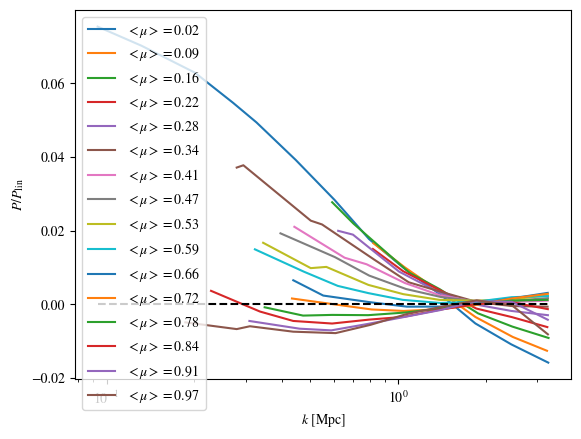

In [54]:
mask = k3d_Mpc[:,0] < 4
for ii in range(0, p3d_Mpc.shape[1]):
    lab = r'$<\mu>=$'+str(np.round(np.nanmean(mu3d[:,ii]), 2))
    plt.plot(k3d_Mpc[mask, ii], p3d_pred[mask, ii]/model_p3d[mask, ii]-1, label=lab)
plt.plot(k3d_Mpc[mask, 0], k3d_Mpc[mask, 0]*0, 'k--')
plt.xscale('log')
plt.xlabel(r'$k$ [Mpc]')
plt.ylabel(r'$P/P_{\rm lin}$')
plt.legend()

In [68]:
# mask = k1d_Mpc < 4
# plt.plot(k1d_Mpc[mask], p1d_pred[mask]/model_p1d[mask]-1, '-', label='Sim/Model-1')
# plt.plot(k1d_Mpc[mask], k1d_Mpc[mask]*0, 'k--')
# plt.xscale('log')
# plt.xlabel(r'$k$ [Mpc]')
# plt.ylabel(r'$P_{\rm 1D}$')
# plt.legend()